## Connecting to the Database

In [2]:
pip install psycopg2-binary;

  Using cached psycopg2_binary-2.8.6-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import psycopg2

In [4]:
# Put the password in 
PGHOST = 'tripdatabase2.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [5]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



In [6]:
import pandas as pd
import numpy as np
import Queries
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [7]:
lookup_query = """SELECT * FROM lookup"""
lookup_table = Queries.execute_query(conn, lookup_query, to_frame=True)

In [6]:
pd.set_option('display.max_colwidth', None)

In [41]:
profile_query = """
        with station_count AS (
            SELECT code, COUNT(*) 
              FROM station 
             WHERE birth <= '2020-01-01' 
                   AND (death >= '2020-01-01' 
                        or death IS NULL)
             GROUP BY code
        )
        SELECT *
          FROM profile
          LEFT JOIN station_count
         USING (code);
        """
profile_df = Queries.execute_query(conn, profile_query, to_frame=True)
profile_df.fillna(value={'count':0}, inplace=True)  # Neighborhoods with no stations are entered as null values
profile_df.replace(-1, np.nan, inplace=True)   # Missing data was inputted into the database as -1
profile_df.set_index('code',inplace=True)

## Inputting Missing Data
To input the missing data into the 11 columns we will input the median value of the column. 

In [42]:
profile_df.loc[:,profile_df.isna().any()];  # Finding where the missing column data is

In almost all the columns of the dataframe there are values that skew the data in some way. When working with neighborhood data there is always values that skew an individual neighborhood's data which then skews the overall data. For the missing values we will input the missing data with the median of all the neighborhoods. 

*Originally, the plan was to input data based on the median of the borough that the specific neighborhood is in, however we will be clustering the neighborhoods and by inputting the median value grouped by the borough we are assuming that neighborhoods in the same borough have the same characteristics which is itself clustering.*

In [43]:
from sklearn.impute import SimpleImputer

In [44]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_mean.fit_transform(profile_df)
columns = profile_df.columns
index = profile_df.index

profile_df = pd.DataFrame(X, columns=columns, index=index)

## Boxplots of Data
Let's take some time to explore the data before we get into the machine learning portion. Since there are a lot of columns we are going to go category by category. The five categories are:
- DEM: Demographics
- HSC: Housing Market & Conditions
- LUD: Land Use & Development
- NSC: Neighborhood Services & Conditions
- RNT: Renters

### Demographics

In [126]:
dem = profile_df.loc[:,profile_df.columns.str[:3] == 'dem']

In [127]:
numbers = ['dem5','dem7','dem8','dem9','dem14']   # Columns that aren't percentages
percents = [i for i in list(dem.columns) if i not in numbers]   # Columns that are percentages 

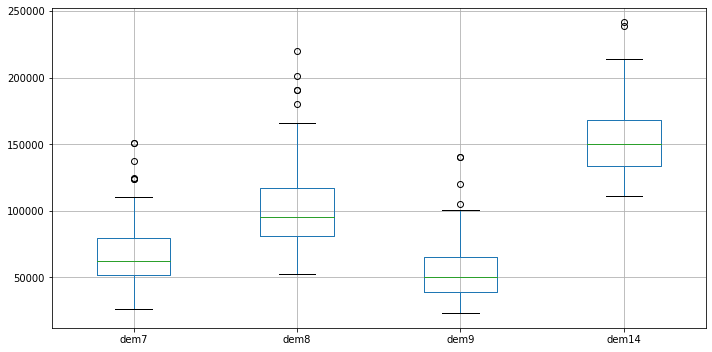

In [128]:
dem[numbers[1:]].boxplot(figsize=(10,5))
plt.tight_layout()

In [129]:
dem[numbers].describe()

,dem5,dem7,dem8,dem9,dem14
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,5.966102,68442.033898,106749.152542,56637.118644,153489.966102
std,1.504546,30181.167500,36346.386733,27036.813731,29954.177078
min,3.600000,26150.000000,52710.000000,23180.000000,110800.000000
25%,4.800000,51750.000000,80900.000000,39460.000000,133329.500000
50%,5.600000,62720.000000,95690.000000,50040.000000,150131.000000
75%,6.850000,79995.000000,117055.000000,65160.000000,168311.000000
max,9.700000,150600.000000,220070.000000,140090.000000,241539.000000


DEM8/9 are a subdivision of DEM7 which refers to the median household income of all members of the household aged 15 and over. I believe that this demographic will play a large role in determining the number of stations a neighborhood has. For example, lower income neighborhoods may be more attractive because those people would be looking for a cheaper alternative for transporation. On the flip side, higher income neighborhoods may be more attractive because they have more money to spend. 

DEM14 may also play a large role in deciding the number of stations. As we say in the last notebook the number of people each station serves divided by the voronoi area of the station tends to be under a threshold. 

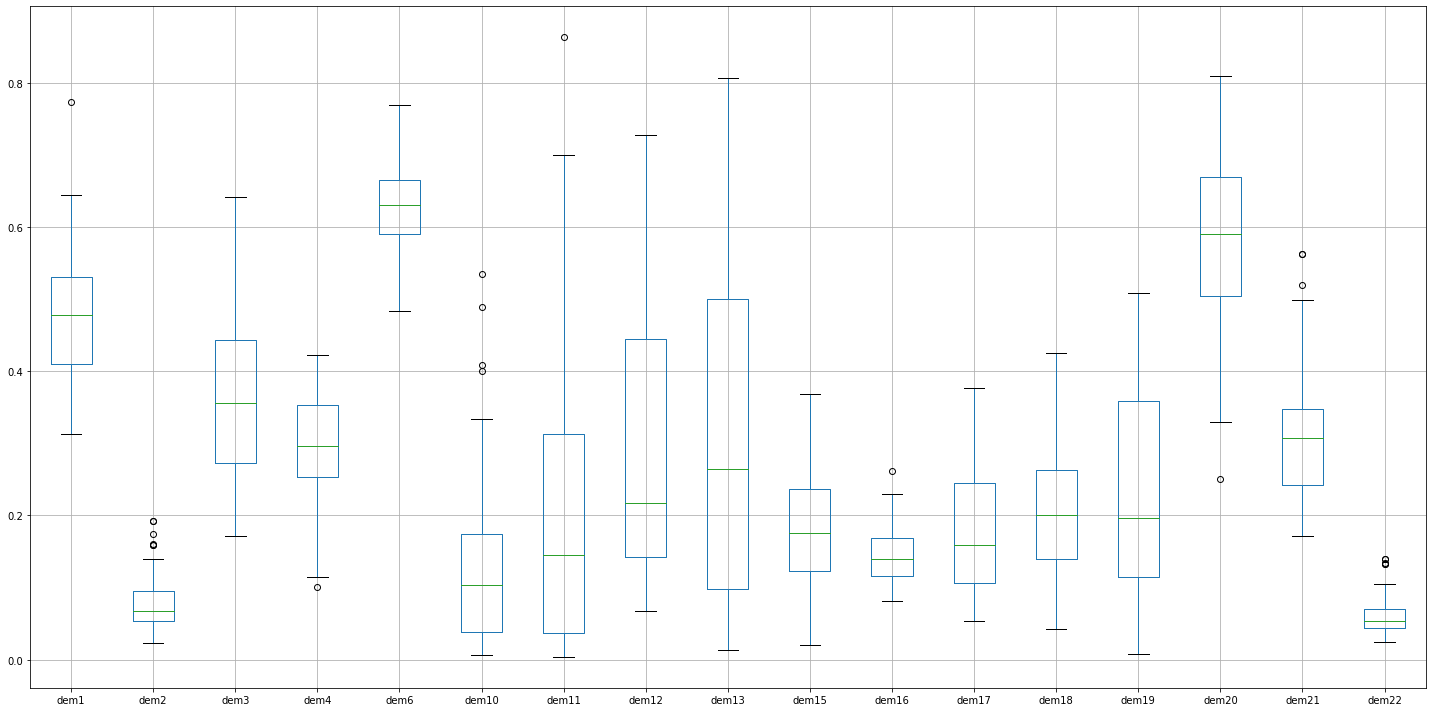

In [130]:
dem[percents].boxplot(figsize=(20,10))
plt.tight_layout()

In [131]:
dem[percents].describe()

,dem1,dem2,dem3,dem4,dem6,dem10,dem11,dem12,dem13,dem15,dem16,dem17,dem18,dem19,dem20,dem21,dem22
count,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.481356,0.080390,0.359017,0.291119,0.63478,0.133492,0.214729,0.298169,0.321966,0.177644,0.145627,0.179576,0.204407,0.229068,0.581186,0.317881,0.060927
std,0.089503,0.040323,0.117478,0.081308,0.06226,0.125464,0.220568,0.206382,0.241586,0.086797,0.040249,0.092851,0.092176,0.143636,0.108946,0.094711,0.028656
min,0.313000,0.023000,0.172000,0.101000,0.48400,0.007000,0.004000,0.067000,0.013000,0.020000,0.082000,0.054000,0.043000,0.008000,0.250000,0.171000,0.024500
25%,0.409500,0.053500,0.272500,0.254000,0.59100,0.039000,0.037000,0.142000,0.098500,0.123000,0.116500,0.106500,0.140000,0.115000,0.505000,0.242500,0.043800
50%,0.478000,0.068000,0.356000,0.297000,0.63000,0.103000,0.145000,0.218000,0.264000,0.176000,0.139000,0.159000,0.201000,0.197000,0.590000,0.308000,0.053100
75%,0.530500,0.095500,0.443500,0.353000,0.66550,0.174000,0.313000,0.444500,0.500000,0.237000,0.169000,0.245000,0.263000,0.359000,0.670000,0.347500,0.069750
max,0.774000,0.192000,0.642000,0.422000,0.76900,0.535000,0.863000,0.728000,0.806000,0.368000,0.262000,0.377000,0.425000,0.509000,0.810000,0.562000,0.140200


DEM4 could be a huge factor in the number of stations an area has. Only people 16+ can use the service, and if there is a large percentage of houses with kids then that reduces the number of people that can use the service. On the flip side, that also can be seen as a potential spot for growth. If the company establishes their presence in those areas, then kids wouldn't be shy to try it when they are of age. Additionally, their parents might favor the bike share over getting a car, or even getting a bicycle. 

DEM6 as well because people that have jobs not only have money but have a place to go on a regular basis and requires transportation.

DEM2/16 could be a large influence because these are the people that most likely wouldn't use the bike share service

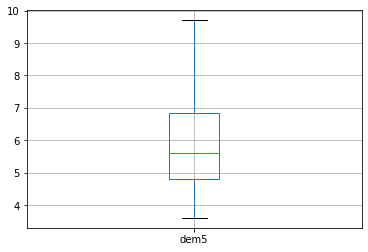

In [132]:
dem[['dem5']].boxplot()

NYC has a large gap between the 20th and 80th percentiles for the majority of neighborhoods. 'Naturally' the 80th percentile should be 4x more than the 20th percentile. If the 80th is less than 4x then that means the 'rich' people of the area don't make that much more money than the 'poor' people. If it's more than 4x than the 'rich' people of the area make significantly more than the 'poor' people. Almost every neighborhood in the city has an income diversity ratio of more than 4. The borough of Manhattan being the worst culprit, holding 7 spots in the top 10 highest income diversity ratios.

#### Correlations Within Demographics Family
In each indicator family we are going to check the correlation plot and then we are going to check the correlation plot of the entire df.

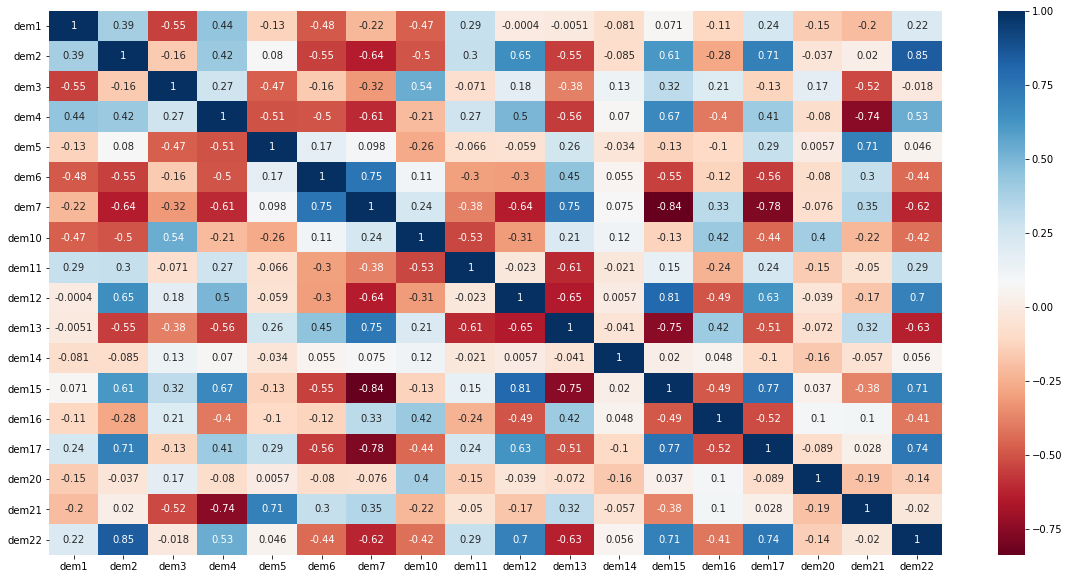

In [136]:
plt.figure(figsize=(20,10))
sns.heatmap(dem.corr(), cmap='RdBu', annot=True);

There are properties that are divided into subdivisions and these subdivisions are stored as seperate properties. For example DEM17 is the poverty rate, DEM18 is the poverty rate for population aged 65+, and DEM19 is the poverty rate for population under 18 years old. These subdivisions are added multicollinearity to the data. 

The issue is that a PCA Dimensionality reduction is going to be fit to the data in a later step and if a base property makes up most of the variance in a componenet then the subdivision will as well. Any child property that is correlated to the base property will be deleted.

In [45]:
profile_df.drop(columns=['dem18','dem19'], inplace=True);   # Poverty subdivisions
profile_df.drop(columns=['dem8','dem9'], inplace=True);   # Median household income subdivisions

### Housing Market & Conditions

In [52]:
hsc = profile_df.loc[:,profile_df.columns.str[:3] == 'hsc']

In [ ]:
# Implementing the Drop Rule
profile_df.drop(columns=['hsc53'], inplace=True);  # Serious housing code violation subdivision of total housing code violations 

There are three properties that are broken into subdivisions in the same way:
- Index of housing price appreciation (HSC23:HSC27)
- Median sales price per unit (HSC30:HSC33)
- Sales volume (HSC48:52)

Each property is split by the type of building. Unfortunately, the median sales price per unit property doesn't have a base. Meaning there isn't a median sales price per unit for all buildings there are only the four subdivisions. If there was a base we would simply delete all the subdivisions and keep it. Because there is know total we can't delete the subdivisions and if we can't delete them in this category we can't delete them in the other categories. 

The purpose of deleting subdivisions is that we don't need them to represent the neighborhood, because the base represents the neighborhood. Using the same ideology we then only need to find the type of building/s that represent the majority of the neighborhood. To do that, we will use the Sales Volume category. Which building/s get bought the most often we wil keep as columns. 

In [49]:
hsc.loc[:,'hsc48':'hsc52'].sum()   # HSC51 is the total

hsc48    11433.0
hsc49    10757.0
hsc50     1323.0
hsc51    33996.0
hsc52    10483.0
dtype: float64

1, 2-4, and condominiums are the most purchased buildings overall. We will keep the properties that relate to those buildings and delete the ones that don't (including the totals).

In [50]:
profile_df.drop(columns=['hsc25','hsc26'], inplace=True)   # Index of housing price 5+ and ALL
profile_df.drop(columns=['hsc32'], inplace=True)   # Median sales per unit 5+
profile_df.drop(columns=['hsc50','hsc51'], inplace=True)   # Sales volume 5+ and ALL
profile_df.drop(columns=['hsc41','hsc42'], inplace=True)   # If there is a foreclosure then there was a preforeclosure for sure
profile_df.drop(columns=['hsc38','hsc39','hsc40'], inplace=True) # We are only keeping the notices of foreclosure of buildings 1-4 and condos

In [55]:
hsc = profile_df.loc[:,profile_df.columns.str[:3] == 'hsc']

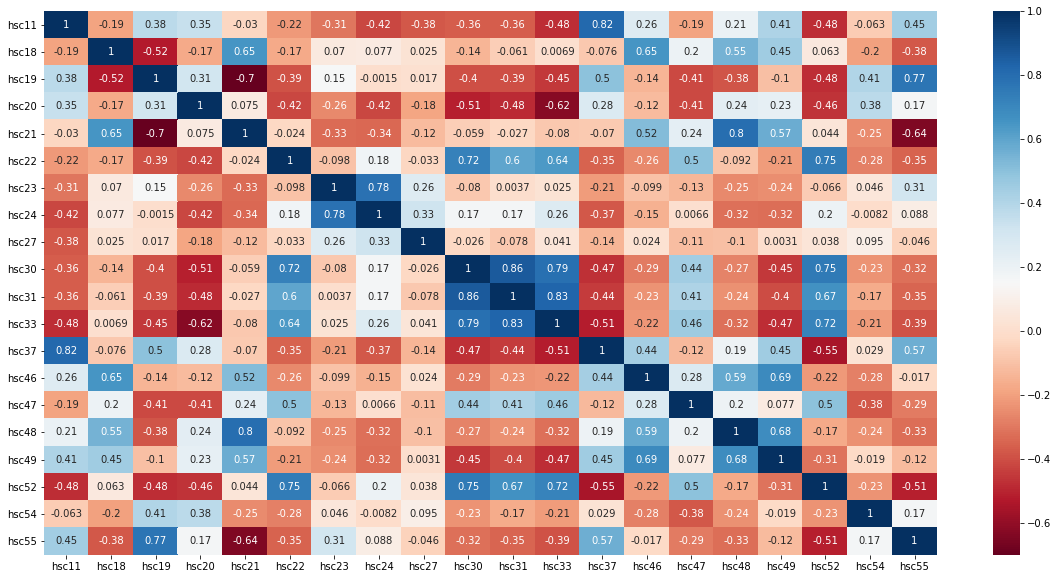

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(hsc.corr(), cmap='RdBu', annot=True);

### Land Use & Development

In [14]:
lud = profile_df.loc[:,profile_df.columns.str[:3] == 'lud']

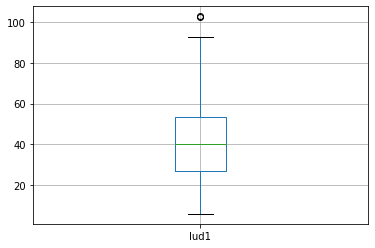

In [23]:
lud[['lud1']].boxplot()

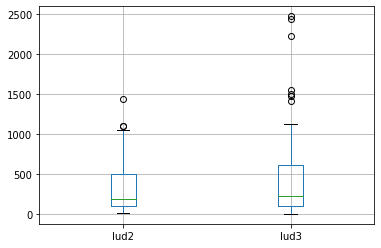

In [25]:
lud[['lud2','lud3']].boxplot()

### Neighborhood Services & Conditions

In [67]:
nsc = profile_df.loc[:,profile_df.columns.str[:3] == 'nsc']

In [78]:
numbers = ['nsc2','nsc3','nsc4','nsc5']   # Columns that aren't percentages
percents = [i for i in list(nsc.columns) if i not in numbers]   # Columns that are percentages 

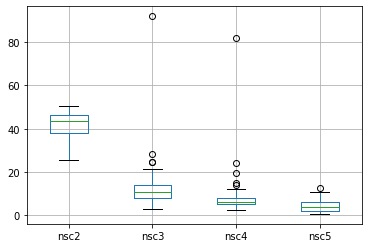

In [79]:
nsc[numbers].boxplot()

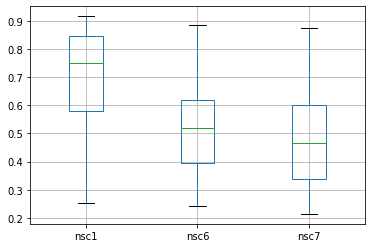

In [80]:
nsc[percents].boxplot()

## Regrouping NYC K-Means Clustering

dfdffdf

### Step 1: Rescaling the Data

In [149]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

In [150]:
W = profile_df.drop(columns='count')   # The clustering is only on the neighborhood properties
columns = W.columns
index = W.index

The data needs to be scaled because the clustering algorithm uses a euclidean based distance metric. Even more so, there are a mixture of percents, regular numbers, and different units within the dataframe. Just using StandardScaler could potentially have a skew in the scaling due to the outlier values that exists in the different properties. What we'll do instead is use RobustScaler since it scales using the median and IQR instead of te mean and the standard deviation. 

After the Robust Scaling we will follow up with a StandardScaler to ensure that each column has a mean of 0 and a std of 1.

In [151]:
robust = RobustScaler()
W = robust.fit_transform(W)

In [152]:
pd.DataFrame(W).describe()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.027735,0.294996,0.017643,-0.059408,0.178586,0.064157,0.202586,0.305882,0.256697,0.225863,...,-0.030474,-0.112099,0.240126,0.173571,0.527735,-0.087338,-0.678802,-0.126632,0.200762,1.044746
std,0.739693,0.960078,0.687003,0.821296,0.733925,0.835702,1.068549,1.005294,1.052016,0.929366,...,0.789666,0.728951,0.675193,0.661893,1.670187,0.623786,1.502073,0.728233,1.043895,2.109709
min,-1.363636,-1.071429,-1.076023,-1.979798,-0.975610,-1.959732,-1.294742,-1.188771,-1.045136,-0.711111,...,-1.676768,-1.742574,-0.600000,-0.448133,-1.295455,-1.269279,-4.429577,-1.517241,-2.480620,-0.080000
25%,-0.566116,-0.345238,-0.488304,-0.434343,-0.390244,-0.523490,-0.388387,-0.409072,-0.411673,-0.474074,...,-0.535354,-0.643564,-0.241860,-0.443983,-0.409091,-0.522124,-0.718310,-0.649425,-0.356589,-0.080000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.433884,0.654762,0.511696,0.565657,0.609756,0.476510,0.611613,0.590928,0.588327,0.525926,...,0.464646,0.356436,0.758140,0.556017,0.590909,0.477876,0.281690,0.350575,0.643411,0.920000
max,2.446281,2.952381,1.672515,1.262626,2.000000,1.865772,3.111347,3.440188,3.503891,3.200000,...,1.979798,2.099010,1.888372,2.348548,5.613636,0.877370,0.352113,1.609195,3.379845,7.400000


Even after the RobustScaling there are still columns that vary more than the others.

In [153]:
standard = StandardScaler()
W = standard.fit_transform(W)

In [154]:
X = pd.DataFrame(W, columns=columns, index=index)

In [155]:
X.describe()

,dem1,dem2,dem3,dem4,dem5,dem6,dem7,dem8,dem9,dem10,...,rnt7,rnt8,rnt9,rnt10,rnt11,rnt12,rnt13,rnt14,rnt15,rnt16
count,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,...,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01
mean,5.268855e-17,-2.116951e-17,3.010774e-17,2.258081e-17,-6.021549e-17,-9.408670e-18,2.634428e-17,-6.491982e-17,3.293034e-18,-2.822601e-17,...,-2.963731e-17,-8.467803e-18,2.822601e-17,3.575294e-17,2.258081e-17,9.220496e-17,-4.139815e-17,5.457028e-17,5.645202e-18,-6.562547e-17
std,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,...,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00
min,-1.897159e+00,-1.435460e+00,-1.605602e+00,-2.358316e+00,-1.586134e+00,-2.442572e+00,-1.413301e+00,-1.499544e+00,-1.248088e+00,-1.016840e+00,...,-2.102692e+00,-2.255942e+00,-1.254956e+00,-9.473435e-01,-1.100978e+00,-1.911051e+00,-2.518501e+00,-1.925959e+00,-2.590680e+00,-5.377046e-01
25%,-8.097259e-01,-6.725806e-01,-7.427766e-01,-4.604360e-01,-7.817051e-01,-7.092134e-01,-5.578086e-01,-7.172938e-01,-6.407769e-01,-7.595988e-01,...,-6.448459e-01,-7.353405e-01,-7.199778e-01,-9.410207e-01,-5.657256e-01,-7.029939e-01,-2.652825e-02,-7.240557e-01,-5.384979e-01,-5.377046e-01
50%,-3.781713e-02,-3.099000e-01,-2.590150e-02,7.295493e-02,-2.454191e-01,-7.742864e-02,-1.912170e-01,-3.068828e-01,-2.460995e-01,-2.451154e-01,...,3.892254e-02,1.551018e-01,-3.586935e-01,-2.644846e-01,-3.186859e-01,1.412155e-01,4.557890e-01,1.753815e-01,-1.939709e-01,-4.994592e-01
75%,5.537918e-01,3.779424e-01,7.253149e-01,7.676036e-01,5.925279e-01,4.976575e-01,3.860730e-01,2.859792e-01,3.179384e-01,3.256397e-01,...,6.323820e-01,6.482698e-01,7.737936e-01,5.827663e-01,3.814926e-02,9.138817e-01,6.449330e-01,6.609184e-01,4.276755e-01,-5.963692e-02
max,3.297730e+00,2.791644e+00,2.429503e+00,1.623510e+00,2.503047e+00,2.174317e+00,2.745527e+00,3.144565e+00,3.113134e+00,3.227648e+00,...,2.567576e+00,3.059314e+00,2.462103e+00,3.314202e+00,3.071248e+00,1.559814e+00,6.922191e-01,2.404075e+00,3.071545e+00,3.038242e+00


Now every column has a mean of zero with a standard deviation of 1

### Step 2: Performing Dimensionality Reduction using PCA

There are 79 features in our dataset and with suc a large feature space it may difficult difficult to cluster the neighborhoods effectively. Before sending the data to the K-Means algorithmn we are going to reduce the dimensionality of our data. 

Code Derived From:

https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/US-census_population_segmentation_PCA_Kmeans/sagemaker-countycensusclustering.ipynb 

In [156]:
import sagemaker
import boto3
import io
import sagemaker.amazon.common as smac
import os

In [157]:
sagemaker_session = sagemaker.Session()

bucket = 'williams-citibike'
prefix = 'pca'
output_location = f"s3://{bucket}/{prefix}/output"

role = sagemaker.get_execution_role()

In [158]:
pca_model = sagemaker.PCA(role = role,
                          instance_count = 1,
                          instance_type = 'ml.m5.large',
                          output_path = output_location,
                          use_spot_instances = True,
                          max_run = 600,
                          max_wait = 600,
                          feature_dim = 79,
                          num_components = 78,
                          mini_batc_size = 5)

In [ ]:
pca_model.fit(pca_model.record_set(X.values))

In [165]:
job_name = pca_model.latest_training_job.name 
#job_name = 'pca-2021-01-27-16-23-23-714'
model_key = "pca/output/" + job_name + "/output/model.tar.gz"
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz');
os.system('tar -zxvf model.tar.gz');

In [ ]:
pip install mxnet

In [166]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [168]:
s = pd.DataFrame(pca_model_params['s'].asnumpy())   # The singular values of the components for the PCA transformation
v = pd.DataFrame(pca_model_params['v'].asnumpy())   # The principal components

In [169]:
explained_variance_ratio = s.apply(lambda x: x*x) / s.apply(lambda x: x*x).sum()   # Calculates the explained variance ratio
explained_variance_ratio = explained_variance_ratio.sort_values(by=0, ascending=False)
explained_variance_ratio['explained_ratio_sum'] = explained_variance_ratio[0].cumsum()   # Sum of explained variance from great -> least
explained_variance_ratio.head(10) 

,0,explained_ratio_sum
77,0.361775,0.361775
76,0.187224,0.548999
75,0.085267,0.634266
74,0.051416,0.685682
73,0.041548,0.727230
72,0.034018,0.761248
71,0.027589,0.788837
70,0.025426,0.814263
69,0.020615,0.834878
68,0.018729,0.853607


Components 77-72 explain 76% of the data's variance. We will take those 6 components and send them to the KMeans

In [170]:
s_6 = s.iloc[72:,:]
v_6 = v.iloc[:,72:]
v_6.columns = [0,1,2,3,4,5]

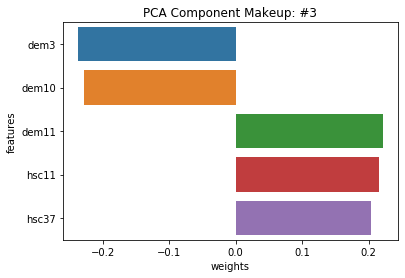

In [189]:
component_num = 3

first_comp = v_6[6-component_num]
components_df = pd.DataFrame(list(zip(X.columns,first_comp)), columns=['features','weights'])
components_df['abs_weights'] = components_df['weights'].apply(lambda x: np.abs(x))
ax = sns.barplot(data=components_df.sort_values('abs_weights', ascending=False).head(), x='weights', y='features')
ax.set_title('PCA Component Makeup: #' + str(component_num));

In [ ]:
# All of those weights are the same thing - some sort of median income
# Get rid of subcategories

#### Deploying the PCA Model

In [190]:
pca_predictor = pca_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m5.large')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------!

In [191]:
result = pca_predictor.predict(X.values)

In [230]:
X_pca_transform = pd.DataFrame()
for i in result:
    b = i.label['projection'].float32_tensor.values
    X_pca_transform = X_pca_transform.append([list(b)])

X_pca_transform.index = index
X_pca_transform = X_pca_transform.iloc[:,72:]
X_pca_transform.columns = ['comp6','comp5','comp4','comp3','comp2','comp1']

In [240]:
X_pca_transform.head()

,comp6,comp5,comp4,comp3,comp2,comp1
code,,,,,,
BK01,0.749656,0.510125,-3.350094,0.456951,-3.456627,4.604521
BK02,0.988841,1.249660,-2.997066,1.520231,-2.742215,6.317334
BK03,0.069628,0.276634,-4.091921,2.677952,-2.070266,-1.005393
BK04,-0.405988,-0.666948,-2.919968,0.376141,-3.153388,-1.265471
BK05,0.767380,-1.356881,-0.285694,4.466129,0.712544,-5.502057


#### Running the KMeans

In [238]:
prefix = 'kmeans'
output_location = f"s3://{bucket}/{prefix}/output"

In [242]:
kmeans_model = sagemaker.KMeans(role = role,
                                instance_count = 1,
                                instance_type = 'ml.m5.large',
                                use_spot_instances = True,
                                max_run = 600,
                                max_wait = 600,
                                k = 5,
                                feature_dim = 6,
                                output_path = output_location)

In [244]:
kmeans_model.fit(kmeans_model.record_set(X_pca_transform.values.astype('float32')))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-27 19:52:19 Starting - Starting the training job...
2021-01-27 19:52:42 Starting - Launching requested ML instancesProfilerReport-1611777138: InProgress
......
2021-01-27 19:53:43 Starting - Preparing the instances for training......
2021-01-27 19:54:48 Downloading - Downloading input data...
2021-01-27 19:55:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/27/2021 19:55:37 INFO 140340076598848] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvst

In [246]:
kmeans_predictor = kmeans_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m5.large')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!

In [337]:
from sagemaker.deserializers import JSONDeserializer
kmeans_predictor.deserializer = JSONDeserializer()

In [338]:
result = kmeans_predictor.predict(X_pca_transform.values.astype('float32'))

In [358]:
clusters = [r['closest_cluster'] for r in result['predictions']]
clusters = pd.DataFrame(clusters, index=index, columns=['cluster'])

# Next we are going to determine what each cluster represents